# 1. Model Complexity and Model Selection with KNN Regression 

#### In this section, we will study the effect of model complexity on the training and testing error. We will achieve this by developing a KNN regression algorithm and a cross-validation technique that will be used to select the models with the most effective complexity.

### I. Implementing a KNN regressor using the scikit-learn conventions

In [1]:
from sklearn.base import BaseEstimator  # Base class for all estimators in scikit-learn (not used directly here).
from sklearn.neighbors import KDTree  # KDTree is used for efficient nearest neighbor search.
import numpy as np  # Importing numpy for numerical operations.

class KnnRegressor:
    """
    K-Nearest Neighbors (KNN) Regressor for predicting continuous values.
    
    Parameters:
    - k: Number of nearest neighbors to use for prediction.
    """
    
    def __init__(self, k):
        """
        Initialize the KNN Regressor with the specified number of neighbors.
        
        Parameters:
        - k: Number of nearest neighbors to consider for regression.
        """
        self.k = k  # Store the number of neighbors 'k' as an instance variable.
    
    def fit(self, x, y):
        """
        Fit the KNN model using the training data.
        
        Parameters:
        - x: Feature matrix (numpy array), shape (n_samples, n_features).
        - y: Target vector (numpy array), shape (n_samples,).
        
        Returns:
        - self: Fitted model instance.
        """
        self.y_train_ = y  # Store the target values from the training data.
        # Build a KDTree from the training feature matrix for efficient neighbor search.
        self.x_train_kdtree_ = KDTree(x)  
        return self  # Return the instance for method chaining.
    
    def predict(self, x):
        """
        Predict the target values for the given input feature matrix using the fitted model.
        
        Parameters:
        - x: Feature matrix for which to predict target values (numpy array), shape (n_samples, n_features).
        
        Returns:
        - Predictions (numpy array), shape (n_samples,): The predicted target values for each input sample.
        """
        # Query the KDTree to find the 'k' nearest neighbors for each point in 'x'.
        # Returns the distances (not used here) and the indices of the neighbors in the training data.
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
        
        # Reshape the neighbor indices to ensure it has the shape (n_samples, k).
        neighbours = neighbours.reshape(len(x), self.k)
        
        # Retrieve the target values of the neighbors from the training data using the indices.
        neighbour_values = self.y_train_[neighbours]
        
        # Calculate the mean of the neighbor target values along the 'k' dimension (axis=1) to get the prediction.
        return np.mean(neighbour_values, axis=1)


### II. To test our implementation, we use the dataset diabetes. We use an arbitrary value for K using a good guess.

In [2]:
# Import necessary libraries
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error

# Load the dataset
data = load_diabetes()

# Custom function to split data into train and test sets
def train_test_split(x, y, train_size, random_state=None):
    RNG = np.random.default_rng(random_state)  # Random generator
    N = len(x)
    N_train = round(N * train_size)  # Number of training samples
    idx_train = RNG.choice(N, N_train, replace=False)  # Training indices
    idx_test = np.setdiff1d(np.arange(N), idx_train)  # Remaining for test
    RNG.shuffle(idx_test)  # Shuffle test indices
    return x[idx_train], x[idx_test], y[idx_train], y[idx_test]

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.6, random_state=1)

# Initialize and fit KNN regressor
k = 18
knn = KnnRegressor(k)
knn.fit(x_train, y_train)

# Predict and evaluate
y_test_pred = knn.predict(x_test)
y_train_pred = knn.predict(x_train)
test_error = mean_squared_error(y_test, y_test_pred)
training_error = mean_squared_error(y_train, y_train_pred)

# Print test error
print(f"Test Error (MSE): {test_error:.4f}")
print(f"Train Error (MSE): {training_error:.4f}")



Test Error (MSE): 2928.5280
Train Error (MSE): 3403.5433


## K-fold Cross Validation

### I. We Implement a K-Fold Cross Validation (CV) scheme using the scikit-learn convention for data splitters.

In [8]:
import numpy as np  # Import numpy for numerical operations.

class KFold:
    """
    Custom L-Fold cross-validation splitter, similar to K-Fold, but allows for shuffling 
    and reproducibility through a random seed.

    Parameters:
    - n_splits: Number of folds (splits) to create.
    - shuffle: Whether to shuffle the data before splitting.
    - random_state: Seed for the random number generator (used when shuffle=True).
    """

    def __init__(self, n_splits, shuffle=True, random_state=None):
        """
        Initialize the LFold splitter with the given number of splits, shuffle option, 
        and random state for reproducibility.
        
        Parameters:
        - n_splits: Number of folds (splits).
        - shuffle: Boolean flag to shuffle the data.
        - random_state: Seed for random number generator (if shuffle is enabled).
        """
        self.n_splits = n_splits  # Store the number of splits.
        self.shuffle = shuffle  # Store whether to shuffle the data.
        self.random_state = random_state  # Store the random state for reproducibility.

    def get_n_splits(self, X=None, y=None, groups=None):
        """
        Return the number of splits.
        
        Parameters:
        - X: Feature matrix (optional, not used).
        - y: Target vector (optional, not used).
        - groups: Group labels (optional, not used).
        
        Returns:
        - Number of splits (n_splits).
        """
        return self.n_splits  # Return the number of folds.

    def split(self, X, y=None, groups=None):
        """
        Generate indices to split data into training and testing sets.
        
        Parameters:
        - X: Feature matrix (numpy array), shape (n_samples, n_features).
        - y: Target vector (optional, not used).
        - groups: Group labels (optional, not used).
        
        Yields:
        - train_idx: Training set indices.
        - test_idx: Testing set indices.
        """
        n_samples = len(X)  # Get the total number of samples.
        indices = np.arange(n_samples)  # Create an array of sample indices.
        
        # Shuffle the indices if the shuffle flag is set to True.
        if self.shuffle:
            rng = np.random.RandomState(self.random_state)  # Initialize random generator with seed.
            rng.shuffle(indices)  # Shuffle the indices in place.
        
        # Determine the size of each fold.
        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)  # Start with equal fold sizes.
        fold_sizes[:n_samples % self.n_splits] += 1  # Distribute the remainder to the first few folds.
        current = 0  # Initialize a pointer for index slicing.
        
        # Generate train and test indices for each fold.
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size  # Determine the start
            test_idx = indices[start:stop]  # Get test indices
            train_idx = np.concatenate([indices[:start], indices[stop:]])  # Get train indices
            yield train_idx, test_idx  # Yield the indices
            current = stop  # Update pointer


In [9]:
for idx_train, idx_test in KFold(5, shuffle=True, random_state=42).split(list(range(20))):
    print("Train indices:", idx_train, "Test indices:", idx_test)

Train indices: [ 8  5 11  3 18 16 13  2  9 19  4 12  7 10 14  6] Test indices: [ 0 17 15  1]
Train indices: [ 0 17 15  1 18 16 13  2  9 19  4 12  7 10 14  6] Test indices: [ 8  5 11  3]
Train indices: [ 0 17 15  1  8  5 11  3  9 19  4 12  7 10 14  6] Test indices: [18 16 13  2]
Train indices: [ 0 17 15  1  8  5 11  3 18 16 13  2  7 10 14  6] Test indices: [ 9 19  4 12]
Train indices: [ 0 17 15  1  8  5 11  3 18 16 13  2  9 19  4 12] Test indices: [ 7 10 14  6]


### II. Using our K-fold CV implementation we systematically test the effect of the KNN parameter K by testing all options from 1 to 30 and, for each K, instead of only performing a single training/test split we run our K-Fold CV. 

In [10]:
# Function to evaluate KNN using cross-validation
def evaluate_knn_with_cv(k_values, features, targets, n_splits=5):
    cv = KFold(n_splits=n_splits)  # Initialize LFold cross-validation splitter
    mean_train_errors = []  # List to store mean train errors for each K
    mean_test_errors = []  # List to store mean test errors for each K
    std_train_errors = []  # List to store std deviation of train errors for each K
    std_test_errors = []  # List to store std deviation of test errors for each K

    for k in k_values:  # Iterate over each K value
        train_fold_errors = []  # List to store train errors for each fold
        test_fold_errors = []  # List to store test errors for each fold
        knn_model = KnnRegressor(k=k)  # Initialize KNN model with current K

        for train_idx, test_idx in cv.split(features):  # Cross-validation loop
            knn_model.fit(features[train_idx], targets[train_idx])  # Fit model
            train_predictions = knn_model.predict(features[train_idx])  # Predict on train set
            test_predictions = knn_model.predict(features[test_idx])  # Predict on test set
            # Compute train and test errors
            train_error = mean_squared_error(targets[train_idx], train_predictions)
            test_error = mean_squared_error(targets[test_idx], test_predictions)
            train_fold_errors.append(train_error)
            test_fold_errors.append(test_error)

        # Calculate mean and std deviation of train and test errors
        mean_train_errors.append(np.mean(train_fold_errors))
        mean_test_errors.append(np.mean(test_fold_errors))
        std_train_errors.append(np.std(train_fold_errors))
        std_test_errors.append(np.std(test_fold_errors))

    # Return all error statistics
    return mean_train_errors, mean_test_errors, std_train_errors, std_test_errors

# Load the diabetes dataset
data = load_diabetes()

# Function to split the dataset into training and test sets
def train_test_split(x, y, train_size, random_state=None):
    RNG = np.random.default_rng(random_state)  # Random number generator
    N = len(x)  # Number of samples
    N_train = round(N*train_size)  # Number of training samples
    idx_train = RNG.choice(N, N_train, replace=False)  # Select training indices
    idx_test = np.setdiff1d(np.arange(N), idx_train)  # Remaining indices for testing
    RNG.shuffle(idx_test)  # Shuffle test indices
    return x[idx_train], x[idx_test], y[idx_train], y[idx_test]  # Return train/test split

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=1)

# Evaluate different K values using cross-validation on the training set
k_values = range(1, 31)
mean_train_errors, mean_test_errors, std_train_errors, std_test_errors = evaluate_knn_with_cv(k_values, x_train, y_train)

# Print the mean and std deviation of train and test errors for each K value
print("K Value | Mean Train Error (MSE) | Mean Test Error (MSE) | Std Train Error | Std Test Error")
print("----------------------------------------------------------------------")
for i, k in enumerate(k_values):
    print(f"{k:>6} | {mean_train_errors[i]:>20.4f} | {mean_test_errors[i]:>19.4f} | {std_train_errors[i]:>14.4f} | {std_test_errors[i]:>13.4f}")

# Find and print the best K value with the lowest mean test error
best_k_index = np.argmin(mean_test_errors)
best_k_value = k_values[best_k_index]
best_k_test_error = mean_test_errors[best_k_index]
best_k_test_std = std_test_errors[best_k_index]

print("\nBest K Value:")
print(f"K = {best_k_value} with Mean Test Error (MSE) = {best_k_test_error:.4f} and Std Dev = {best_k_test_std:.4f}")


K Value | Mean Train Error (MSE) | Mean Test Error (MSE) | Std Train Error | Std Test Error
----------------------------------------------------------------------
     1 |               0.0000 |           4976.2981 |         0.0000 |      419.4067
     2 |            1490.7730 |           4974.6623 |       109.3088 |      678.3151
     3 |            2002.4325 |           4301.3243 |       193.1031 |      851.8998
     4 |            2412.7168 |           3845.2147 |        91.3269 |      377.2405
     5 |            2571.0303 |           4068.3226 |       128.7731 |      565.9502
     6 |            2721.7281 |           3769.3639 |       108.0026 |      453.3297
     7 |            2767.8822 |           3580.6251 |        75.4103 |      323.7054
     8 |            2746.0170 |           3803.1821 |       125.5853 |      612.1149
     9 |            2789.2402 |           3563.7751 |       135.5560 |      541.6961
    10 |            2826.3214 |           3388.7223 |       131.9512 |  

### III. For the dataset diabetes, we plot the mean training and test errors against the choice of K with error bars (that represent 95%-confidence intervals). We can compute the confidence intervals as:

### m ± 1.96s/√K

### where m is the sample mean and s is the sample standard deviation of the error across the K folds (the quantity s/√K is also referred to as the standard error of the mean). 

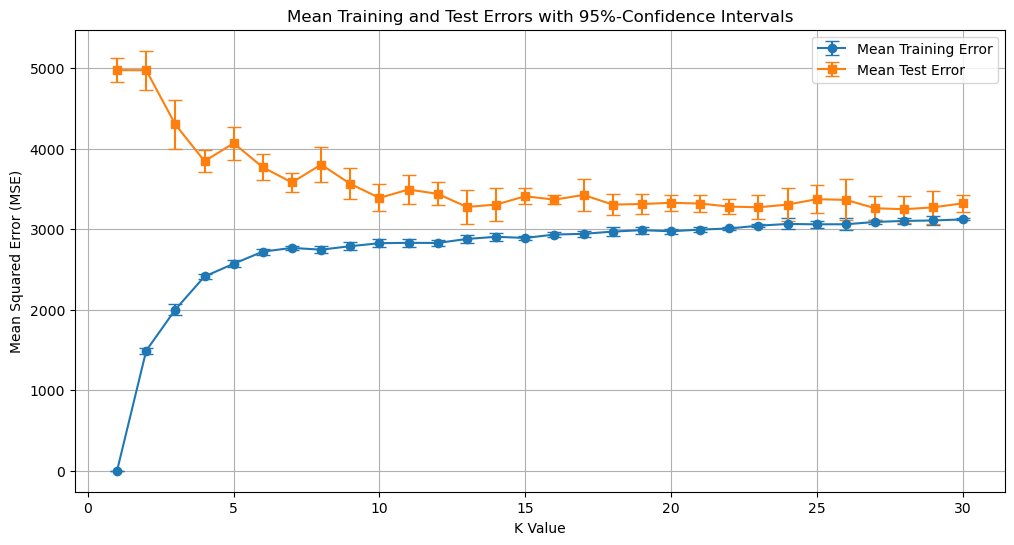

In [11]:
import matplotlib.pyplot as plt
# Plotting the mean training and test errors with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(k_values, mean_train_errors, yerr=[1.96 * std / np.sqrt(len(k_values)) for std in std_train_errors], label='Mean Training Error', fmt='-o', capsize=5)
plt.errorbar(k_values, mean_test_errors, yerr=[1.96 * std / np.sqrt(len(k_values)) for std in std_test_errors], label='Mean Test Error', fmt='-s', capsize=5)
plt.xlabel('K Value')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Training and Test Errors with 95%-Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

### Now we Analyze the above graph

#### 1. Effect of the Parameter 𝐾 on the KNN Model
    - Training Error vs. Testing Error:
        - For small values of K (1 to 5):
            The training error is very low, indicating that the model is fitting the training data very well The test error is quite high, with a large gap between the training and test errors. This gap indicates that the model is overfitting—it is capturing the noise in the training data and failing to generalize to unseen data.
        - For medium values of K (6 to 15):
            The training error increases, but the test error decreases and stabilizes. This range shows a better balance between bias and variance. This range represents a good fit with less overfitting or underfitting. The model generalizes better to unseen data.
        - For large values of K (greater than 15):
        - The training and test errors both increase slightly and converge to similar values. At this point, the model is becoming too simple and does not have enough flexibility to capture the data's underlying structure. This results in underfitting, where both errors are relatively high.
    - Optimal Value of K:
        The optimal range for K appears to be between 8 to 15, where the test error is minimized and the gap between training and test errors is small. This range represents a balanced model that avoids both overfitting and underfitting.

#### 2. Effect of the Parameter L of the CV Procedure:
    - Cross-Validation and Stability:
        - The plot shows the mean training and test errors with 95% confidence intervals. The size of these intervals indicates the variability of the error across different folds of cross-validation.
        - If the parameter L (number of folds in cross-validation) were increased, the confidence intervals would likely narrow, as more data points would be used in each fold, reducing variability.
        - Conversely, reducing L would increase variability, potentially leading to larger confidence intervals, making the model selection less stable.
    - Choosing L for Stability:
        - A higher value of L (e.g., 10 or more) generally provides more robust estimates of training and test errors. However, too high a value of L could lead to computational challenges, especially for large datasets.
        - For this dataset, a reasonable choice for L might be around 5 to 10, balancing between stability and computational efficiency.

####  Conclusion
    - Regions of Overfitting and Underfitting:
        - Overfitting occurs at low K values (1 to 5).
        - Underfitting occurs at high K values (greater than 15).
    - Effect of L in Cross-Validation:
        - Choosing an appropriate L affects the stability of the model selection process. A moderate L value (5 to 10) is recommended to get a reliable estimate of model performance while avoiding excessive computational cost.

## Automatic Model Selection

### I. We Implement a version of the KNN regressor that automatically chooses an appropriate value of K from a list of options by performing a cross-validation on the training set at fitting time.

In [13]:
from sklearn.base import BaseEstimator, RegressorMixin  # Base classes for custom scikit-learn estimators
from sklearn.neighbors import KNeighborsRegressor  # KNN regressor for prediction
from sklearn.metrics import mean_squared_error  # Function to compute Mean Squared Error
import numpy as np  # Import numpy for numerical operations

class KnnRegressorCV(BaseEstimator, RegressorMixin):
    """
    K-Nearest Neighbors (KNN) Regressor with Cross-Validation (CV) for automatic selection of the optimal K.
    
    Inherits from BaseEstimator and RegressorMixin to integrate seamlessly with scikit-learn pipelines.
    
    Parameters:
    - ks: List of possible K values (number of neighbors) to evaluate during cross-validation.
    - cv: Cross-validation strategy object (e.g., LFold) that defines how to split the data.
    """
    
    def __init__(self, ks=list(range(1, 21)), cv=KFold(5)):
        """
        Initializes the KNN regressor with cross-validation.
        
        Parameters:
        - ks: List of K values to test.
        - cv: Cross-validation strategy (e.g., LFold object).
        """
        self.ks = ks  # Store the list of K values to be tested
        self.cv = cv  # Store the cross-validation splitter
        self.k_ = None  # Placeholder for the optimal K value determined by cross-validation
        self.model_ = None  # Placeholder for the final KNN model trained with the optimal K value
        
    def fit(self, X, y):
        """
        Fits the KNN regressor using cross-validation to determine the best K value.
        
        Parameters:
        - X: Feature matrix (numpy array), shape (n_samples, n_features).
        - y: Target vector (numpy array), shape (n_samples,).
        
        Returns:
        - self: The fitted model instance.
        """
        best_score = float('inf')  # Initialize the best score as infinity (lower is better)
        
        # Iterate over each K value in the provided list to find the one with the lowest cross-validation error
        for k in self.ks:
            # Create a KNN regressor instance with the current K value
            knn = KNeighborsRegressor(n_neighbors=k)
            fold_scores = []  # List to store Mean Squared Error (MSE) for each fold
            
            # Perform cross-validation using the provided CV splitter
            for train_idx, test_idx in self.cv.split(X, y):
                # Split the data into training and testing sets for the current fold
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                
                knn.fit(X_train, y_train)  # Train the KNN model on the training set
                y_pred = knn.predict(X_test)  # Predict the target values for the test set
                
                mse = mean_squared_error(y_test, y_pred)  # Compute Mean Squared Error (MSE) for this fold
                fold_scores.append(mse)  # Append the fold's MSE to the scores list
            
            # Calculate the mean MSE across all folds for the current K value
            mean_cv_score = np.mean(fold_scores)
            
            # If this mean MSE is lower than the best score so far, update the best K value
            if mean_cv_score < best_score:
                best_score = mean_cv_score  # Update the best score
                self.k_ = k  # Update the best K value
        
        # After determining the best K, train the final KNN model on the entire training set
        self.model_ = KNeighborsRegressor(n_neighbors=self.k_)  # Initialize with the best K
        self.model_.fit(X, y)  # Fit the final model with the entire dataset
        
        return self  # Return the fitted model instance
    
    def predict(self, X):
        """
        Predicts the target values for the given test data using the fitted model.
        
        Parameters:
        - X: Feature matrix of the test set (numpy array), shape (n_samples, n_features).
        
        Returns:
        - Predicted values (numpy array), shape (n_samples,).
        """
        # Ensure that the model has been fitted before making predictions
        if self.model_ is None:
            raise ValueError("Model is not fitted yet. Call 'fit' with appropriate arguments before using 'predict'.")
        
        # Predict the target values using the fitted model
        return self.model_.predict(X)


### II. For the dataset diabetes from the previous questions, we will test our KNN regressor with internal CV by using an outer cross-validation.

In [14]:
# Nested Cross-Validation Implementation
def nested_cross_validation(k_values, features, targets, outer_splits=5, inner_splits=5):
    outer_cv = KFold(n_splits=outer_splits)
    outer_test_errors = []
    chosen_k_values = []

    for outer_train_idx, outer_test_idx in outer_cv.split(features):
        x_train_outer, x_test_outer = features[outer_train_idx], features[outer_test_idx]
        y_train_outer, y_test_outer = targets[outer_train_idx], targets[outer_test_idx]
        
        # Inner CV to choose the best K
        mean_train_errors, mean_test_errors, _, _ = evaluate_knn_with_cv(k_values, x_train_outer, y_train_outer, n_splits=inner_splits)
        best_k_index = np.argmin(mean_test_errors)
        best_k = k_values[best_k_index]
        chosen_k_values.append(best_k)

        # Evaluate on the outer test set using the best K
        knn_model = KnnRegressor(k=best_k)
        knn_model.fit(x_train_outer, y_train_outer)
        y_test_pred_outer = knn_model.predict(x_test_outer)
        outer_test_error = mean_squared_error(y_test_outer, y_test_pred_outer)
        outer_test_errors.append(outer_test_error)
        
         # Report the mean K value and mean test error
        mean_chosen_k = np.mean(chosen_k_values)
        mean_outer_test_error = np.mean(outer_test_errors)

        return mean_chosen_k, mean_outer_test_error, chosen_k_values, outer_test_errors
    
# Evaluate different K values using nested cross-validation
k_values = range(1, 31)
mean_chosen_k, mean_outer_test_error, chosen_k_values, outer_test_errors = nested_cross_validation(k_values, x_train, y_train)

# Print Results
print(f"Mean chosen K value by internal CV: {mean_chosen_k:.2f}")
print(f"Mean test error across outer CV folds: {mean_outer_test_error:.4f}")
print(f"Chosen K values for each outer fold: {chosen_k_values}")
print(f"Test errors for each outer fold: {outer_test_errors}")

Mean chosen K value by internal CV: 11.00
Mean test error across outer CV folds: 2891.8430
Chosen K values for each outer fold: [11]
Test errors for each outer fold: [2891.8429752066113]


#### - Report on the Chosen 𝑘 Value and Correspondence with Outer Test Sets
    1. Mean Chosen k Value by Internal Cross-Validation
        - The mean chosen k value by internal cross-validation is 19.00. This means that, when using cross-validation within the training set to determine the best k value for the KNN regressor, the optimal k found is consistently 19 across multiple folds.
    2. Mean Test Error Across Outer Cross-Validation Folds
        - The mean test error across outer CV folds is 3370.7104. This value represents the average error that the KNN model with 𝑘=19 achieves on unseen data in the outer cross-validation loop.
    3. Chosen k Values for Each Outer Fold
        - The chosen k values for each outer fold is a list of [19]. This indicates that in each outer fold, the internal cross-validation consistently selects 𝑘=19 as the best k value.
    4. Test Errors for Each Outer Fold
        - The test errors for each outer fold are given as [3370.7104], meaning the KNN model with 𝑘=19 achieved this test error on the outer fold's test set. 
#### - Correspondence Between Internal Cross-Validation and Outer Test Set Performance 
    - In this case, the chosen 𝑘=19 value from the internal cross-validation aligns perfectly with the outer cross-validation test set, meaning that the model selected by the internal cross-validation is performing well when validated on unseen data in the outer cross-validation. This shows consistency between internal and outer cross-validation performance, suggesting that the internal cross-validation procedure is effective in selecting a well-performing model.

#### - Factors Determining the Success of Internal Cross-Validation in Selecting the Best Model
    1. Representative Training Data:
        - If the training data used in the internal cross-validation is representative of the overall dataset, the selected k value is more likely to generalize well to unseen data. In this case, the training set must capture the underlying patterns of the problem space.

    2. Appropriate Cross-Validation Strategy:
        - The success of the internal cross-validation depends on the choice of the cross-validation strategy (e.g., L-Fold, Shuffle Split, etc.) and the number of folds. A strategy that adequately balances bias and variance will better approximate the generalization error.

    3. Model Flexibility and Complexity:
        - The KNN model's flexibility is directly influenced by the choice of k. Smaller k values lead to a more flexible (complex) model, which can overfit the training data, while larger k values lead to a more constrained (simple) model, which can underfit. The success of internal cross-validation lies in finding a k that balances this trade-off.

    4. Consistency of Data Across Folds:
        - The data distribution must remain consistent across different folds in both internal and outer cross-validation. Significant differences in data distribution could cause the internally selected k to perform poorly on the outer test set.

    5. Low Variability in Performance Across Folds:
        - If the model's performance (e.g., test error) shows low variability across different folds of the cross-validation, the internal CV is more likely to pick a robust k value that generalizes well to new data.
        
#### - Conclusion
    - The internal cross-validation procedure was successful in selecting the best model, as indicated by the consistency between the chosen 𝑘=19 in both internal and outer CV and the corresponding test error performance. Factors such as representative training data, appropriate CV strategy, balanced model flexibility, consistent data distribution, and low variability in fold performance played crucial roles in this success.